# New Sustainedness calcs 
### Main goal:
1. Simple s_index over time for cells that have high trans L5 and same plot for cells that have high sust L5.

In [1]:
%load_ext autoreload
%autoreload 2
import cascade as cas
import flow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
import warnings
from cascade import utils
from scipy.stats import pearsonr
from copy import deepcopy

## load finished sustainedness calcs

In [ ]:
sus_df_idall = pd.read_pickle(f'/twophoton_analysis/Data/analysis/Group-attractive/cell_sus_df_wids.pkl')

## load all data to redo sustainedness calcs

In [2]:
# set parameters
mice = cas.lookups.mice['all12']
# words = ['facilitate'] * len(mice)
words = ['respondent' if s in 'OA27' else 'computation' for s in mice]
group_by = 'all3'

rank_level_sort = 15

# mice = ['OA27']
# words = ['bookmarks']

# load in a full size tensor
model_list = []
tensor_list = []
id_list = []
bhv_list = []
meta_list = []
for mouse, word in zip(mice, words):
    
    # return   model, ids, tensor, meta, bhv
    out = cas.load.load_all_groupday(mouse, word=word, with_model=True, group_by=group_by, nan_thresh=0.95)
    sorted_model, sort_order = utils.sortfactors(out[0])
    model_list.append(sorted_model)
    tensor_list.append(out[2][sort_order[rank_level_sort - 1], :, :])
    id_list.append(out[1][sort_order[rank_level_sort - 1]])
    bhv_list.append(out[4])
    meta_list.append(utils.add_stages_to_meta(out[3], 'parsed_11stage'))

Updated naive cs-ori pairings to match learning.
     135 plus
     270 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     0 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     135 plus
     0 minus
     270 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     135 plus
     0 minus
     270 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match le

In [3]:
pref_tensor_list = []
cell_tuning_list = []
for meta, tensor, model in zip(meta_list, tensor_list, model_list):
    ten, tun = cas.tuning.preferred_tensor(meta, tensor, model, tune_staging='staging_LR', best_tuning_only=True, drop_broad_tuning=False,
                                           staging='parsed_11stage', tuning_type='initial', return_tuning=True)
    pref_tensor_list.append(ten)
    cell_tuning_list.append(tun)

s:\twophoton_analysis\code\cascade\cascade\utils.py:1570: RuntimeWarning: All-NaN slice encountered
  above_thresh = ~np.isnan(np.nanmax(weights, axis=1))
s:\twophoton_analysis\code\cascade\cascade\tuning.py:80: RuntimeWarning: Mean of empty slice
  trial_avg_vec = np.nanmean(cell_mat, axis=0)
s:\twophoton_analysis\code\cascade\cascade\tuning.py:358: RuntimeWarning: Mean of empty slice
  mean_cue.append(np.nanmean(rect_trial_avg_vec[cue_boo]))
s:\twophoton_analysis\code\cascade\cascade\tuning.py:410: RuntimeWarning: Mean of empty slice
  mean_cue.append(np.nanmean(rect_trial_avg_vec[cue_boo]))


In [83]:
# pd.concat(cell_tuning_list, axis=0).set_index(['mouse', 'cell_n']).to_pickle(f'/twophoton_analysis/Data/analysis/Group-attractive/cell_tuning_df.pkl')

## get your sustainedness matrices per mouse

In [4]:
sus_list = []
for meta, pref_tensor in zip(meta_list, pref_tensor_list):
    sus = cas.stability.sustainedness95(meta, pref_tensor, epoch='parsed_11stage', full_trial_window=False,
                      filter_running=None, filter_licking=None, filter_hmm_engaged=True)
    sus_list.append(sus)

s:\twophoton_analysis\code\cascade\cascade\utils.py:324: RuntimeWarning: Mean of empty slice
  trace_mean = np.nanmean(tensor, axis=2)
s:\twophoton_analysis\code\cascade\cascade\utils.py:68: RuntimeWarning: Mean of empty slice
  new_tensor[:, :, c] = np.nanmean(tensor[:, :, stage_boo], axis=2)


In [2]:
# Add in cell ids as a column. start using this as index always
sus_w_id = []
for mouse, sus, ids in zip(mice, sus_list, id_list):
    for c, st in enumerate(cas.lookups.staging['parsed_11stage']):
        df = pd.DataFrame(data={
            'mouse': [mouse] * sus.shape[0],
            'cell_id': ids,
            'cell_n': np.arange(sus.shape[0]) + 1, 
            'parsed_11stage': [st] * sus.shape[0],
            'sustainedness': sus[:, c]})  # this was mislabelled as running corr when it was save before
        sus_w_id.append(df)
sus_df_idall = pd.concat(sus_w_id, axis=0).set_index(['mouse', 'cell_id']).sort_index()
sus_df_idall.head()

NameError: name 'mice' is not defined

In [98]:
sus_df_idall.to_pickle(f'/twophoton_analysis/Data/analysis/Group-attractive/cell_sus_df_wids.pkl')

## get offset vectors

In [5]:
off_list = []
for meta, pref_tensor, mouse in zip(meta_list, pref_tensor_list, mice):
    off = cas.utils.get_offset_cells(meta, pref_tensor)
    off_list.append(pd.DataFrame(data={'mouse': [mouse] * len(off),
                                      'cell_n': np.arange(len(off)) +1,
                                      'offset_cell': off
                                     }
                               ).set_index(['mouse', 'cell_n'])
    )
off_df = pd.concat(off_list, axis=0)
off_df.head()

offset_cell
mouse cell_n             
AS20  1             False
      2             False
      3             False
      4             False
      5             False

## average across all cells 

In [14]:
# make a df of average sustainedness 
stages = cas.lookups.staging['parsed_11stage']
sus_dfs = []
for tun, sus, mouse, off in zip(cell_tuning_list, sus_list, mice, off_list):
    
    usecells = ~tun.set_index(['mouse', 'cell_n'])['learning_tuning'].isin(['broad', 'none']) & ~off.offset_cell
    mean_per_mouse = np.nanmean(sus[usecells, :], axis=0)
    sus_dfs.append(pd.DataFrame(data={'mouse': [mouse] * len(stages),
                                      'parsed_11stage': stages,
                                      'sustainedness_index': mean_per_mouse
                                     }
                               ).set_index('mouse')
    )
sus_df_all = pd.concat(sus_dfs, axis=0)
sus_df_all.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


,parsed_11stage,sustainedness_index
mouse,,
AS20,L0 naive,NaN
AS20,L1 learning,0.644312
AS20,L2 learning,0.630229
AS20,L3 learning,0.638062
AS20,L4 learning,0.640038


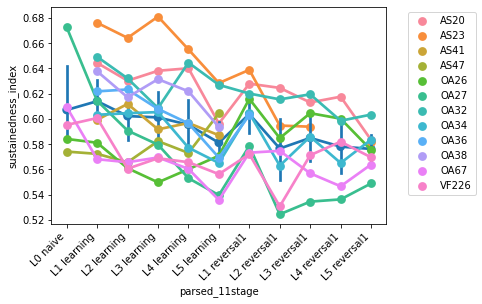

In [15]:
sns.pointplot(data=sus_df_all.reset_index(), x='parsed_11stage', y='sustainedness_index', hue='mouse')
plt.xticks(rotation=45, ha='right');
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0))

sns.pointplot(data=sus_df_all.reset_index(), x='parsed_11stage', y='sustainedness_index')
plt.xticks(rotation=45, ha='right');

## average across all cells and cues

In [58]:
# make a df of average sustainedness accounting for cue
stages = cas.lookups.staging['parsed_11stage']
sus_dfs = []
for tun, sus, mouse, off in zip(cell_tuning_list, sus_list, mice, off_list):
    
    for cue in ['plus', 'minus', 'neutral', 'broad']:
        usecells =  usecells = ~tun.set_index(['mouse', 'cell_n'])['learning_tuning'].isin([cue]) & ~off.offset_cell
        mean_per_mouse = np.nanmean(sus[usecells, :], axis=0)
        sus_dfs.append(pd.DataFrame(data={'mouse': [mouse] * len(stages),
                                          'parsed_11stage': stages,
                                          'sustainedness_index': mean_per_mouse,
                                          'cue': [cue] * len(stages),
                                          'mm_type': ['broad'] * len(stages) if cue == 'broad' else [cas.lookups.lookup_mm[mouse][cue]] * len(stages)
                                         }
                                   ).set_index('mouse')
        )
sus_df_all = pd.concat(sus_dfs, axis=0)
sus_df_all.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


,parsed_11stage,sustainedness_index,cue,mm_type
mouse,,,,
AS20,L0 naive,NaN,plus,becomes_unrewarded
AS20,L1 learning,0.635666,plus,becomes_unrewarded
AS20,L2 learning,0.627492,plus,becomes_unrewarded
AS20,L3 learning,0.632716,plus,becomes_unrewarded
AS20,L4 learning,0.643994,plus,becomes_unrewarded


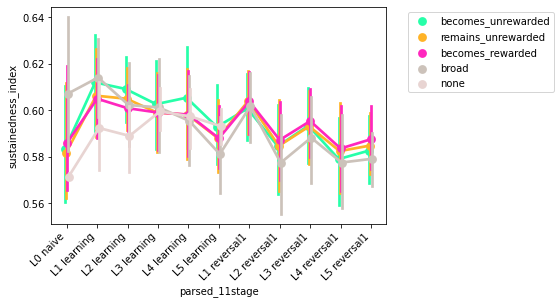

In [59]:
sns.pointplot(data=sus_df_all.reset_index(), x='parsed_11stage', y='sustainedness_index', hue='mm_type', dodge=True, palette=cas.lookups.color_dict)
plt.xticks(rotation=45, ha='right');
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0))


TODO
- slice on high trans L5 and high sus L5 and ask what they did across all time

## Look at L5 transient cells

In [84]:
# make a df of average sustainedness accounting for cue
stages = cas.lookups.staging['parsed_11stage']
sus_dfs = []
for tun, sus, mouse in zip(cell_tuning_list, sus_list, mice):
    
    for cue in ['plus', 'minus', 'neutral', 'broad']:
        usecells = tun['learning_tuning'].isin([cue])
        susboo = (sus[:, 5] < 0.5) #| (sus[:, 4] < 0.5)
        mean_per_mouse = np.nanmean(sus[usecells & susboo, :], axis=0)
        sus_dfs.append(pd.DataFrame(data={'mouse': [mouse] * len(stages),
                                          'parsed_11stage': stages,
                                          'sustainedness_index': mean_per_mouse,
                                          'cue': [cue] * len(stages),
                                          'mm_type': ['broad'] * len(stages) if cue == 'broad' else [cas.lookups.lookup_mm[mouse][cue]] * len(stages)
                                         }
                                   ).set_index('mouse')
        )
sus_df_all = pd.concat(sus_dfs, axis=0)
sus_df_all.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


,parsed_11stage,sustainedness_index,cue,mm_type
mouse,,,,
AS20,L0 naive,NaN,plus,becomes_unrewarded
AS20,L1 learning,0.533043,plus,becomes_unrewarded
AS20,L2 learning,0.543644,plus,becomes_unrewarded
AS20,L3 learning,0.582350,plus,becomes_unrewarded
AS20,L4 learning,0.508612,plus,becomes_unrewarded


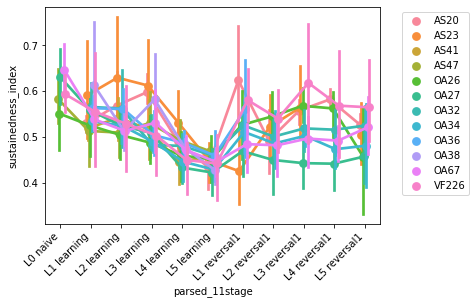

In [62]:
sns.pointplot(data=sus_df_all.reset_index(), x='parsed_11stage', y='sustainedness_index', hue='mouse', dodge=True,)
#               palette=cas.lookups.color_dict)
plt.xticks(rotation=45, ha='right');
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0))

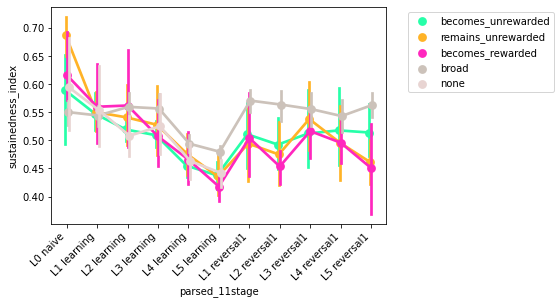

In [63]:
sns.pointplot(data=sus_df_all.reset_index(), x='parsed_11stage', y='sustainedness_index', hue='mm_type', dodge=True, palette=cas.lookups.color_dict)
plt.xticks(rotation=45, ha='right');
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0))

## look at L5 sustained cells

In [76]:
# make a df of average sustainedness accounting for cue
stages = cas.lookups.staging['parsed_11stage']
sus_dfs = []
for tun, sus, mouse in zip(cell_tuning_list, sus_list, mice):
    
    for cue in ['plus', 'minus', 'neutral', 'broad']:
        usecells = tun['learning_tuning'].isin([cue])
        susboo = sus[:, 5] > 0.5
        mean_per_mouse = np.nanmean(sus[usecells & susboo, :], axis=0)
        sus_dfs.append(pd.DataFrame(data={'mouse': [mouse] * len(stages),
                                          'parsed_11stage': stages,
                                          'sustainedness_index': mean_per_mouse,
                                          'cue': [cue] * len(stages),
                                          'mm_type': ['broad'] * len(stages) if cue == 'broad' else [cas.lookups.lookup_mm[mouse][cue]] * len(stages)
                                         }
                                   ).set_index('mouse')
        )
sus_df_all = pd.concat(sus_dfs, axis=0)
sus_df_all.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


,parsed_11stage,sustainedness_index,cue,mm_type
mouse,,,,
AS20,L0 naive,NaN,plus,becomes_unrewarded
AS20,L1 learning,0.719069,plus,becomes_unrewarded
AS20,L2 learning,0.705159,plus,becomes_unrewarded
AS20,L3 learning,0.663421,plus,becomes_unrewarded
AS20,L4 learning,0.678148,plus,becomes_unrewarded


Text(0.5, 1.0, 'becomes_rewarded across mice')

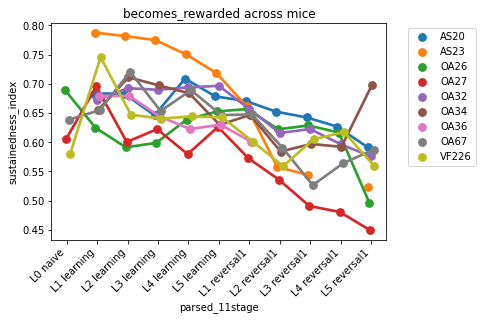

In [77]:
sns.pointplot(data=sus_df_all.loc[sus_df_all.mm_type.isin(['becomes_rewarded'])].reset_index(),
              x='parsed_11stage', y='sustainedness_index', hue='mouse', dodge=True,)
              #palette=cas.lookups.color_dict)
plt.xticks(rotation=45, ha='right');
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0))
plt.title('becomes_rewarded across mice')

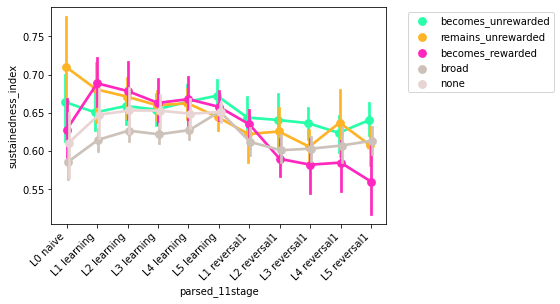

In [78]:
sns.pointplot(data=sus_df_all.reset_index(), x='parsed_11stage', y='sustainedness_index', hue='mm_type', dodge=True,
              palette=cas.lookups.color_dict)
plt.xticks(rotation=45, ha='right');
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0))

## testing L1/L0

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


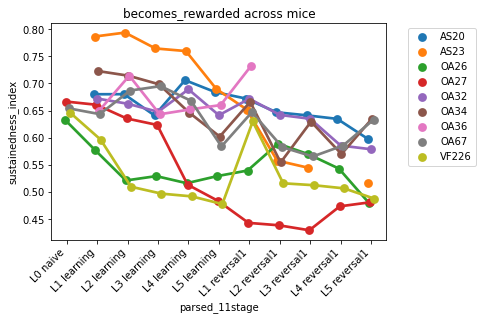

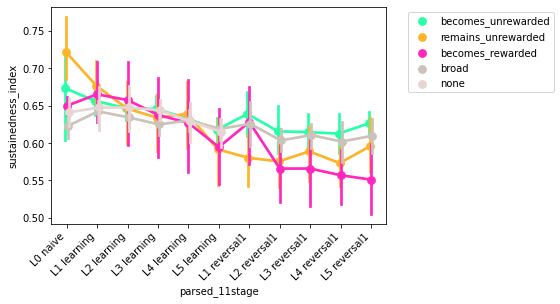

In [73]:
# make a df of average sustainedness accounting for cue
stages = cas.lookups.staging['parsed_11stage']
sus_dfs = []
for tun, sus, mouse in zip(cell_tuning_list, sus_list, mice):
    
    for cue in ['plus', 'minus', 'neutral', 'broad']:
        usecells = tun['learning_tuning'].isin([cue])
        susboo = (sus[:, 0] > 0.5) | (sus[:, 1] > 0.5)
        mean_per_mouse = np.nanmean(sus[usecells & susboo, :], axis=0)
        sus_dfs.append(pd.DataFrame(data={'mouse': [mouse] * len(stages),
                                          'parsed_11stage': stages,
                                          'sustainedness_index': mean_per_mouse,
                                          'cue': [cue] * len(stages),
                                          'mm_type': ['broad'] * len(stages) if cue == 'broad' else [cas.lookups.lookup_mm[mouse][cue]] * len(stages)
                                         }
                                   ).set_index('mouse')
        )
sus_df_all = pd.concat(sus_dfs, axis=0)
sus_df_all.head()

sns.pointplot(data=sus_df_all.loc[sus_df_all.mm_type.isin(['becomes_rewarded'])].reset_index(),
              x='parsed_11stage', y='sustainedness_index', hue='mouse', dodge=True,)
              #palette=cas.lookups.color_dict)
plt.xticks(rotation=45, ha='right');
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0))
plt.title('becomes_rewarded across mice')

plt.figure()
sns.pointplot(data=sus_df_all.reset_index(), x='parsed_11stage', y='sustainedness_index', hue='mm_type', dodge=True,
              palette=cas.lookups.color_dict)
plt.xticks(rotation=45, ha='right');
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0))

TODO
- add time to peak to break up ramping and suppressed cells 
- control for running

In [80]:
meta.columns

Index(['orientation', 'condition', 'initial_condition', 'trialerror',
       'prev_reward', 'prev_punish', 'prev_same_plus', 'prev_same_neutral',
       'prev_same_minus', 'prev_blank', 'hunger', 'learning_state', 'tag',
       'firstlick', 'firstlickbout', 'ensure', 'quinine', 'hmm_engaged',
       'speed', 'pre_speed', 'post_speed', 'anticipatory_licks', 'pre_licks',
       'post_licks', 'pupil', 'pre_pupil', 'neuropil', 'pre_neuropil',
       'brainmotion', 'dprime', 'dprime_run', 'parsed_11stage'],
      dtype='object')